In [4]:
import pandas as pd 
import os
os.chdir('/home/spankaew/Git/astrologics')
import astrologics as le
import seaborn as sns
import matplotlib.pyplot as plt

# Load model path into logic_ensemble object

In [5]:
model_path = '/home/spankaew/Git/astrologics/models/herault_hematopoiesis/'
model = le.LogicEnsemble(model_path, project_name = 'herault_hematopoiesis')
model.create_simulation()

Simulation object created


From `logic_ensemble` object -> you can define simulation parameters and initial condition of the simulation directly. The simulation gives the node activity at each simulation time that is stored in the object called `.simulation.simulation_df`

# Create simulation trajectory from the simulation
When we perform the simulation, the result of the timestep node activity can be visualized using dimension reduction method such as `pca`.

In [6]:
traj_dir = '/home/spankaew/Git/astrologics/models/herault_hematopoiesis' 
traj_data = pd.read_csv('/home/spankaew/Git/astrologics/models/herault_hematopoiesis_traj_df.csv', index_col= 0)
initial_state = traj_data.loc['iHSC']
initial_state = initial_state.dropna().to_dict()

In [8]:
model.simulation.update_parameters(max_time = 30,thread_count = 15, sample_count = 5000)
model.simulation.run_simulation(initial_state=initial_state)
wt_condition = model.simulation.simulation_df

Start simulation


100%|██████████| 616/616 [01:22<00:00,  7.48it/s]

Simulation completed


In [9]:
model.simulation.update_parameters(max_time = 30,thread_count = 15, sample_count = 5000)
model.simulation.mutate(condition = 'Egr1_KI', node = 'Egr1', value = 'ON')
model.simulation.run_simulation(initial_state=initial_state, mutation='Egr1_KI')
egr1_condition = model.simulation.simulation_df

Start simulation


100%|██████████| 616/616 [01:27<00:00,  7.03it/s]

Simulation completed


In [10]:
model.simulation.update_parameters(max_time = 30,thread_count = 15, sample_count = 5000)
model.simulation.mutate(condition = 'Junb_KI', node = 'Junb', value = 'ON')
model.simulation.run_simulation(initial_state=initial_state, mutation='Junb_KI')
junb_condition = model.simulation.simulation_df

Start simulation


100%|██████████| 616/616 [01:16<00:00,  8.10it/s]

Simulation completed


In [13]:
egr1_condition.to_csv('/home/spankaew/Git/astrologics/models/herault_hematopoiesis/hh_egr1_condition.csv')
junb_condition.to_csv('/home/spankaew/Git/astrologics/models/herault_hematopoiesis/hh_junb_condition.csv') 

Trajectory object created


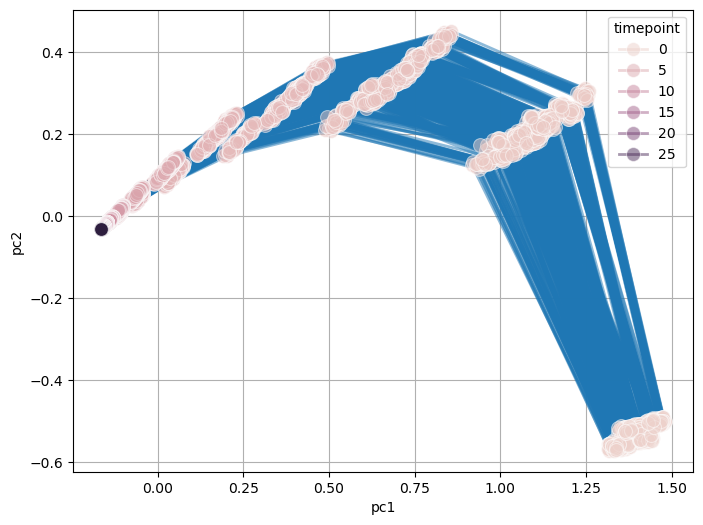

In [12]:
model.create_trajectory()
model.trajectory.pca_trajectory()
model.trajectory.plot_trajectory(color = 'timepoint', show_legend=True)

From the visualization, we can then try to group together models with simular simulation activity via clustering. 

In `logic_ensemble`, we utilize the package called `tslearn` - a toolkit to perform analysis on time series data. 

The timeseries clustering method included in this toolkit includes : 

- euclidean

- dynamic time warping (dtw) 

- softdtw.

The calculated clustering will be embeded into the trajectory matrix

In [ ]:
simulation_df = model.simulation.simulation_df
simulation_df.model_id = simulation_df.model_id.astype('category')
node_list = simulation_df.columns.drop(['timepoint','model_id'])

model_original_all = {}
for i in model_name:
    model_original = simulation_df.loc[simulation_df.model_id == i,node_list].values
    model_original_all[i] = np.array(model_original)
pca_all_trajectory = np.array(list(model_original_all.values()))

100%|██████████| 616/616 [00:23<00:00, 26.33it/s]
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hier

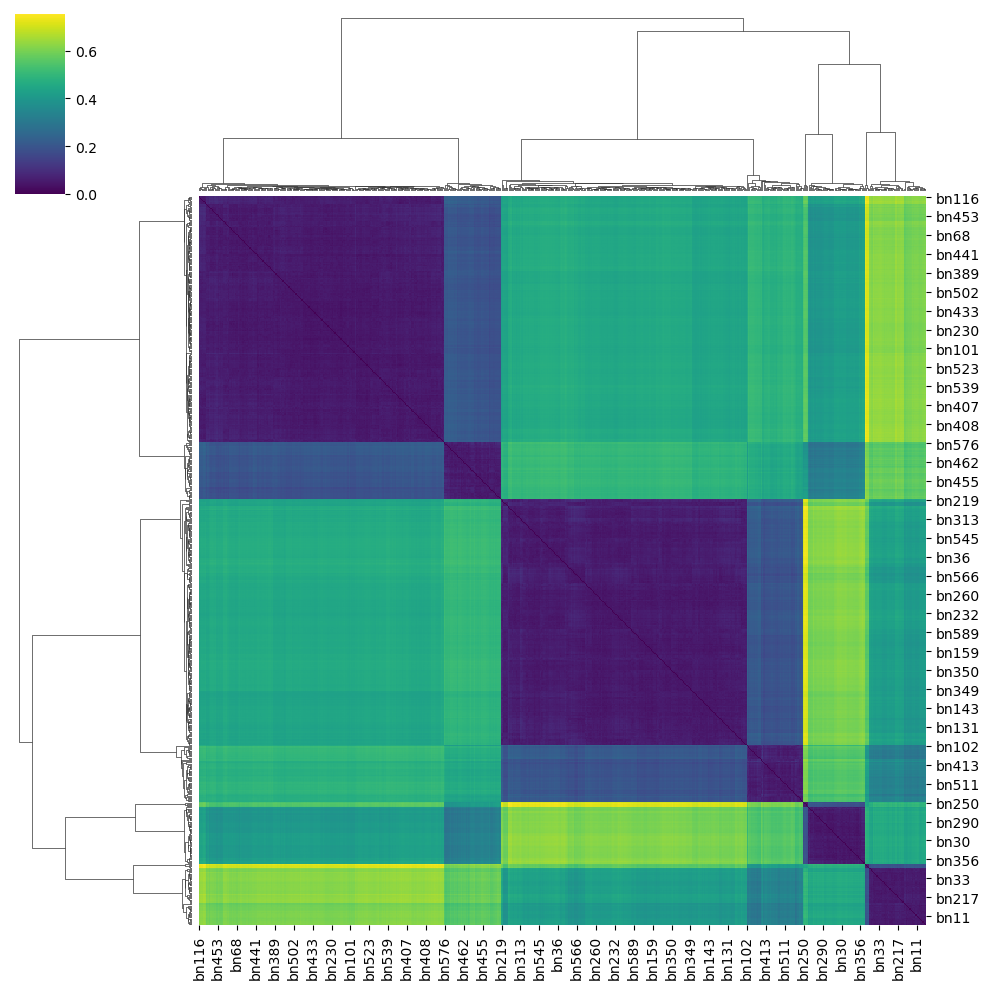

In [8]:
from tslearn.metrics import dtw
from tqdm import tqdm

# Initialize an empty distance matrix
num_trajectories = len(pca_all_trajectory)
distance_matrix = np.zeros((num_trajectories, num_trajectories))

# Calculate DTW distance for each pair of trajectories
for i in tqdm(range(num_trajectories)):
    for j in range(num_trajectories):
        distance_matrix[i, j] = dtw(pca_all_trajectory[i], pca_all_trajectory[j])

# Display the distance matrix
distance_matrix = pd.DataFrame(distance_matrix, index=model_name, columns=model_name)
sns.clustermap(distance_matrix, cmap='viridis', figsize=(10,10))

/tmp/ipykernel_114409/2679887341.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


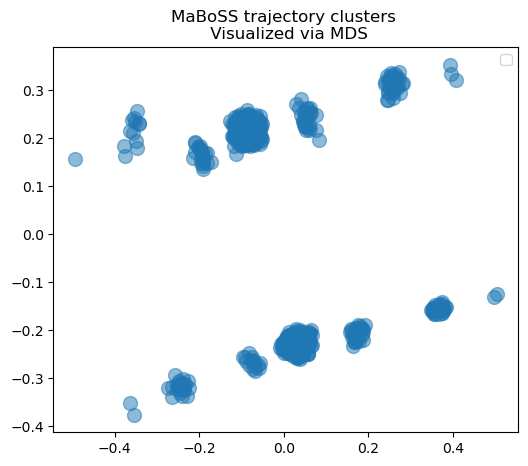

In [9]:
# Visualize clusters with MDS
from sklearn.manifold import MDS

# Visualize clusters with MDS
#distance_matrix = model.succession_diagram.distance_matrix
mds = MDS(dissimilarity='precomputed', random_state=12345)
coords = mds.fit_transform(distance_matrix)

plt.figure(figsize=(6, 5))
plt.scatter(coords[:, 0], coords[:, 1], alpha=0.5, s = 100)
plt.legend()
plt.title('MaBoSS trajectory clusters \n Visualized via MDS')
#plt.savefig('/home/spankaew/Git/astrologics/figures/model_clusters/hh_trajMDS_v3.pdf')

plt.show()

plt.close()

In [10]:
model.trajectory.calculate_kmean_cluster(n_cluster=8, data = 'original', metric = 'dtw')

DTW k-means


/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.

0.003 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.3s


0.002 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.3s


0.002 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.2s


0.002 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.3s


0.002 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.2s


0.002 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.2s


0.002 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.3s
/home/spankaew/Git/astrologics/astrologics/trajectory_clustering.py:222: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pca_df['kmean_cluster'] = pca_df['kmean_cluster'].replace(cluster_dict)
/home/spankaew/Git/astr

In [13]:
# Get traj cluster
model.trajectory.calculate_kmean_cluster(n_cluster=10, data = 'original', metric = 'dtw')
cluster_dict_df = pd.DataFrame(list(model.trajectory.cluster_dict.items()), columns=['Model', 'traj_cluster'])
cluster_dict_df.set_index('Model', inplace=True)

coords_vis = pd.DataFrame(coords, columns = ['x', 'y'], index = distance_matrix.index)
coords_vis = pd.concat([coords_vis, cluster_dict_df],axis = 1)

DTW k-means


/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.

0.003 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.4s


0.002 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.4s


0.002 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.4s


0.002 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.4s


0.002 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.4s


0.002 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.4s


0.002 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.4s


0.002 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    0.4s
/home/spankaew/Git/astrologics/astrologics/trajectory_clustering.py:222: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_s

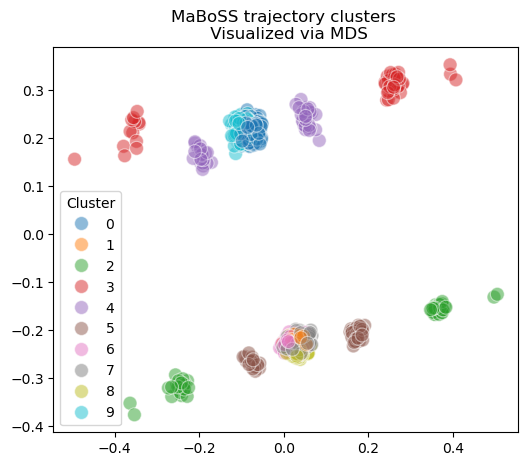

In [14]:
plt.figure(figsize=(6, 5))
sns.scatterplot(data=coords_vis, x='x', y='y', hue='traj_cluster', palette='tab10', alpha=0.5, s=100)
plt.legend(title='Cluster')
plt.title('MaBoSS trajectory clusters \n Visualized via MDS')
plt.xlabel(None)
plt.ylabel(None)

#plt.savefig('/home/spankaew/Git/astrologics/figures/model_clusters/hh_trajMDS_cluster.pdf')

plt.show()
plt.close()

# Create logic function matrix
In this part of the script, we load models' logic function into a matrix. This matrix can then be transformed into a Disjunctive Normal Form (DNF) which allow us to identify clause of components that can activate each node. 

In [ ]:
model.create_logic()

Loading models logics


100%|██████████| 616/616 [00:00<00:00, 857.83it/s]


Concatenate results into matrix


100%|██████████| 616/616 [00:00<00:00, 1626.66it/s]


Logic object created


bn168  \
Bclaf1                                                 (Myc)   
CDK46CycD                                     (Bclaf1 & Myc)   
CIPKIP                                                (Junb)   
Cebpa                     (Gata2 & !Ikzf1) | (!Ikzf1 & Spi1)   
Egr1                                          (Gata2 & Junb)   
Fli1                                (Junb) | (Gata1 & !Klf1)   
Gata1            (Fli1) | (Gata1 & !Ikzf1) | (Gata2 & !Spi1)   
Gata2      (Egr1 & !Gata1 & !Spi1) | (Egr1 & !Zfpm1) | (!...   
Ikzf1                                                (Gata2)   
Junb                                          (Egr1) | (Myc)   
Klf1                                         (!Fli1 & Gata1)   
Myc                                         (Bclaf1 & Cebpa)   
Spi1             (Cebpa & !Gata1 & !Gata2) | (!Gata1 & Spi1)   
Tal1                                         (Gata1 & !Spi1)   
Zfpm1                                                (Gata1)   

                                                       bn602  \
Bclaf1                                                 (Myc)   
CDK46CycD                                     (Bclaf1 & Myc)   
CIPKIP                                                (Junb)   
Cebpa                     (Gata2 & !Ikzf1) | (!Ikzf1 & Spi1)   
Egr1                                          (Gata2 & Junb)   
Fli1       (Gata1 & Junb) | (Gata1 & !Klf1) | (Junb & !Klf1)   
Gata1            (Fli1) | (Gata1 & !Ikzf1) | (Gata2 & !Spi1)   
Gata2      (Egr1 & !Gata1 & !Zfpm1) | (Egr1 & Gata2 & !Sp...   
Ikzf1                                                (Gata2)   
Junb                                          (Egr1) | (Myc)   
Klf1                                         (!Fli1 & Gata1)   
Myc                                         (Bclaf1 & Cebpa)   
Spi1             (Cebpa & !Gata1 & !Gata2) | (!Gata1 & Spi1)   
Tal1                                         (Gata1 & !Spi1)   
Zfpm1                                                (Gata1)   

                                                       bn157  \
Bclaf1                                                 (Myc)   
CDK46CycD                                     (Bclaf1 & Myc)   
CIPKIP                                                (Junb)   
Cebpa                     (Gata2 & !Ikzf1) | (!Ikzf1 & Spi1)   
Egr1                                          (Gata2 & Junb)   
Fli1       (Gata1 & Junb) | (Gata1 & !Klf1) | (Junb & !Klf1)   
Gata1            (Fli1) | (Gata1 & !Ikzf1) | (Gata2 & !Spi1)   
Gata2      (Egr1 & !Zfpm1) | (!Gata1 & Gata2 & !Spi1) | (...   
Ikzf1                                                (Gata2)   
Junb                                          (Egr1) | (Myc)   
Klf1                                         (!Fli1 & Gata1)   
Myc                                         (Bclaf1 & Cebpa)   
Spi1             (Cebpa & !Gata1 & !Gata2) | (!Gata1 & Spi1)   
Tal1                                         (Gata1 & !Spi1)   
Zfpm1                                                (Gata1)   

                                                        bn45  \
Bclaf1                                                 (Myc)   
CDK46CycD                                   (Bclaf1) | (Myc)   
CIPKIP                                                (Junb)   
Cebpa                     (Gata2 & !Ikzf1) | (!Ikzf1 & Spi1)   
Egr1                                          (Gata2 & Junb)   
Fli1                                (Junb) | (Gata1 & !Klf1)   
Gata1      (Fli1) | (Gata1 & !Ikzf1 & !Spi1) | (Gata2 & !...   
Gata2      (Egr1 & !Gata1 & !Spi1 & !Zfpm1) | (!Gata1 & G...   
Ikzf1                                                (Gata2)   
Junb                                          (Egr1) | (Myc)   
Klf1                                         (!Fli1 & Gata1)   
Myc                                         (Bclaf1 & Cebpa)   
Spi1             (Cebpa & !Gata1 & !Gata2) | (!Gata1 & Spi1)   
Tal1                                         (Gata1 & !Spi1)   
Zfpm1               

Flatten models logic clauses


100%|██████████| 616/616 [00:00<00:00, 2493910.49it/s]


Concatenate results into matrix


100%|██████████| 616/616 [00:00<00:00, 1649.32it/s]
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Flattend logic clause created


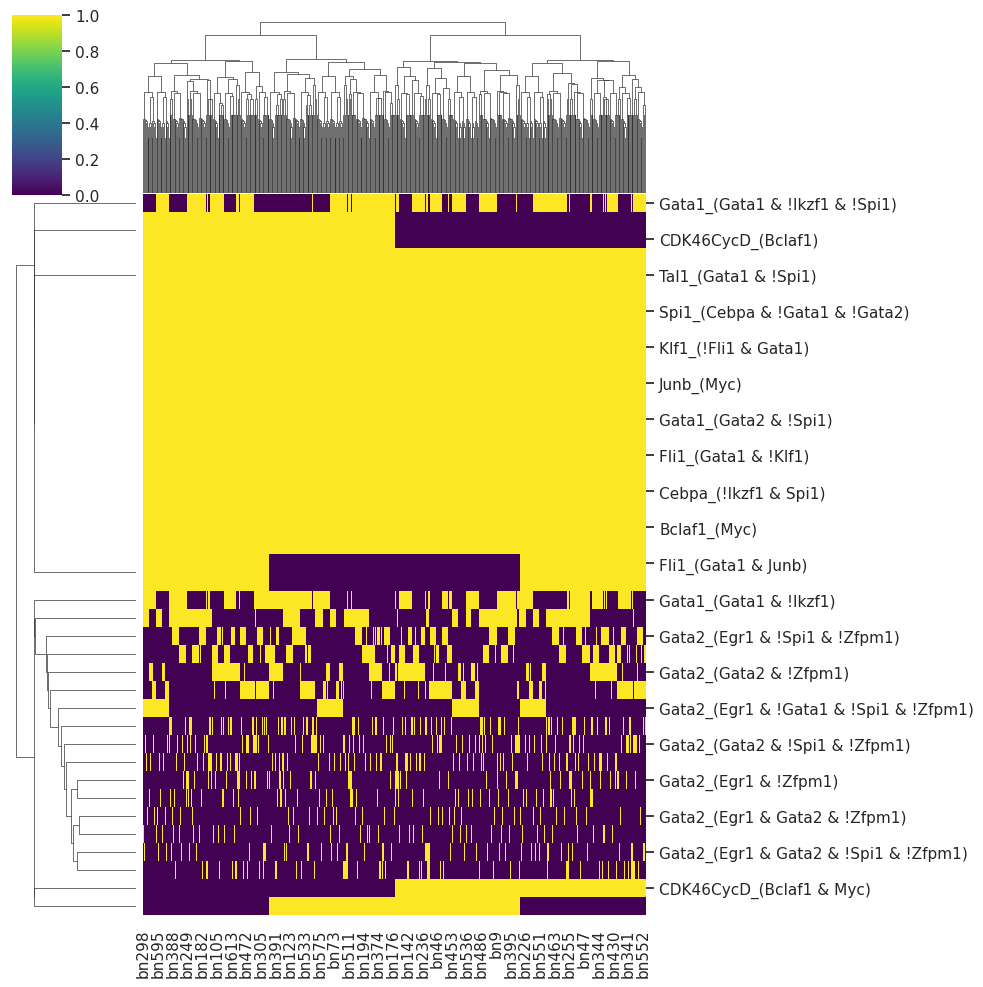

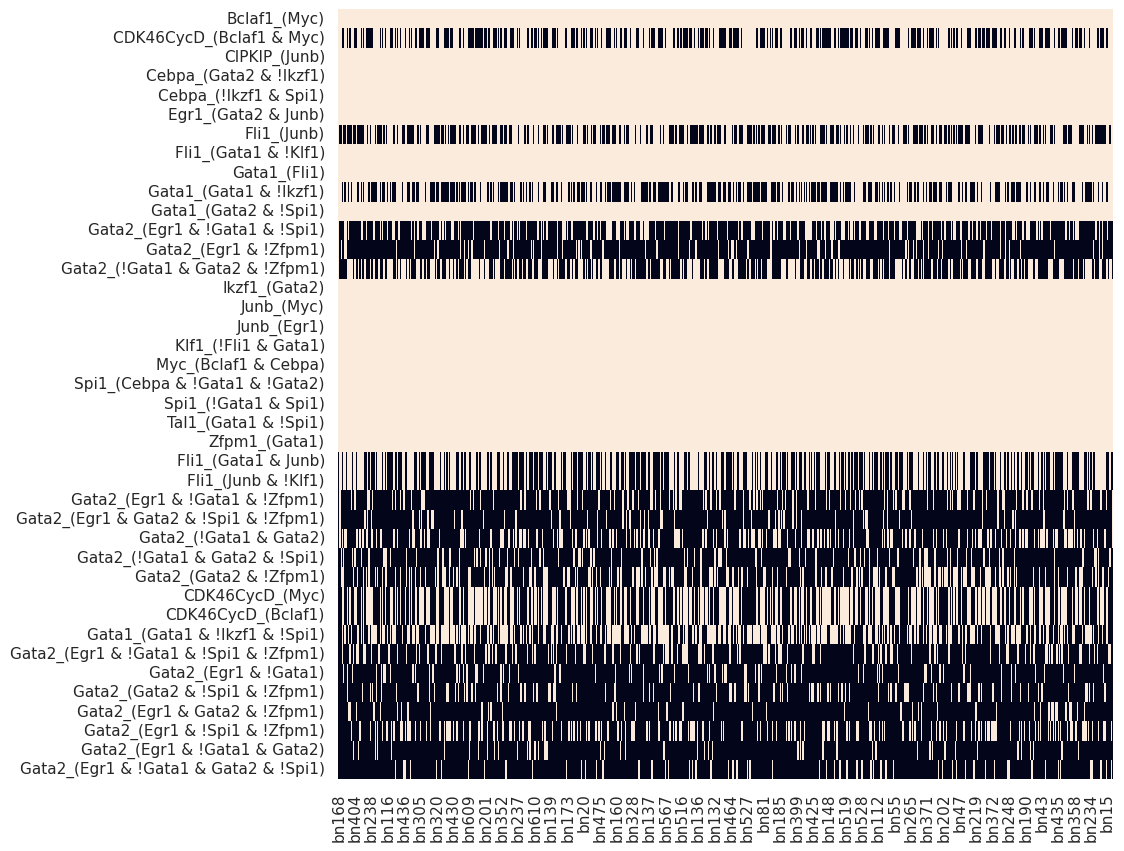

In [36]:
model.logic.create_flattend_logic_clause()
# Create the clustermap
clustermap = sns.clustermap(model.logic.logic_clause_flattend, 
                            cmap='viridis', vmax=1, vmin=0, figsize=(10,10))

# Get the row and column order from the clustermap
row_order = clustermap.dendrogram_row.reordered_ind
col_order = clustermap.dendrogram_col.reordered_ind

# Reorder the dataframe
reordered_df = model.logic.logic_clause_flattend.iloc[row_order, col_order]
# Plot the heatmap with the reordered dataframe without color bar
plt.figure(figsize=(10,10))
sns.heatmap(model.logic.logic_clause_flattend, vmax=1, vmin=0, cbar=False)
#plt.savefig('/home/spankaew/Git/BooleanBenchmark/figures/toy_reprogramming_Logic.pdf')
plt.show()
plt.close()

In [37]:
model.logic.calculate_logic_pca()

PCA calculated


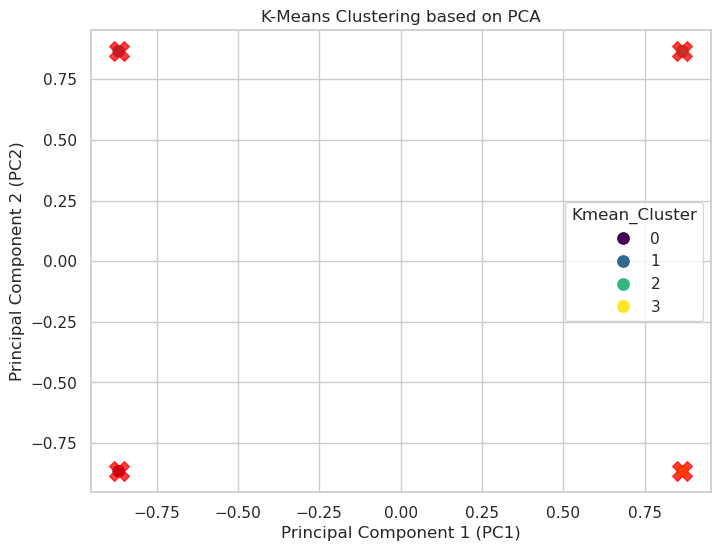

In [38]:
model.logic.calculate_kmean_cluster(num_cluster = 4)

In [41]:
from sklearn.preprocessing import OrdinalEncoder
model_cluster = pd.Series(model.trajectory.cluster_dict)
model_logic = model.logic.model_logic

var_logic_clust = pd.DataFrame()
for i in list(model_cluster.unique()):
    model_logic_sub = model_logic.transpose().loc[list(model_cluster.index[model_cluster == i])]
    #model_logic_sub = model_logic_sub.drop(['logic_cluster'], axis = 1)
    var_logic_length = []
    for j in model_logic_sub.columns:
        num_logic = model_logic_sub[j].value_counts().size
        var_logic_length.append(num_logic)
    var_logic_length = pd.DataFrame(var_logic_length, columns = ['logic_length'], index = model_logic_sub.columns)
    var_logic_clust = pd.concat([var_logic_clust, var_logic_length], axis = 1, ignore_index = False)
var_logic_clust.columns = list(model_cluster.unique())

model_logic_t= model_logic.transpose()

# Ordinal encoding
encoder = OrdinalEncoder()
encoded_data = encoder.fit_transform(model_logic_t)
encoded_df = pd.DataFrame(encoded_data, columns=model_logic_t.columns)

sort_index = encoded_df.max().sort_values().index

var_logic_clust= var_logic_clust.loc[sort_index] 

/tmp/ipykernel_22182/2269529814.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_22182/2269529814.py:5: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(


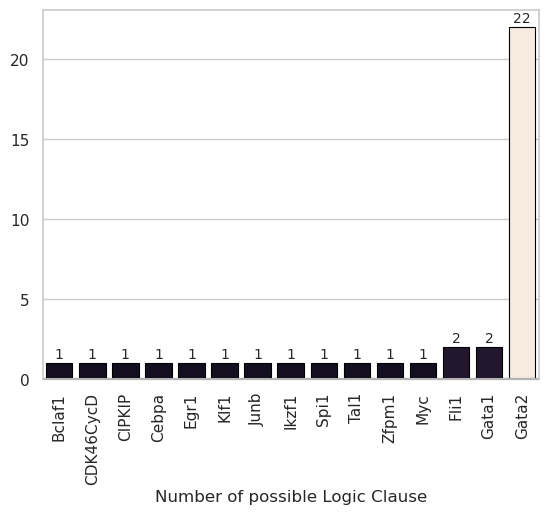

In [86]:
# Sort the dataframe by logic_length
sorted_var_logic_length = var_logic_length.sort_values(by='logic_length', ascending=True)

# Create a barplot with sorted values and color based on logic_length
sns.barplot(
    x=sorted_var_logic_length.index, 
    y=sorted_var_logic_length.logic_length, 
    edgecolor='black',
    linewidth=0.8,
    palette=sns.color_palette("rocket", as_cmap=True)(sorted_var_logic_length.logic_length / sorted_var_logic_length.logic_length.max())

)

# Add a horizontal line at y=0
plt.axhline(0, color="k", clip_on=False)
plt.ylabel(None)
plt.xlabel('Number of possible Logic Clause')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Set labels and title
# Add numbers on top of the bars
for index, value in enumerate(sorted_var_logic_length.logic_length):
    plt.text(index, value + 0.1, str(value), ha='center', va='bottom', fontsize=10)

# Show the plot
plt.show()

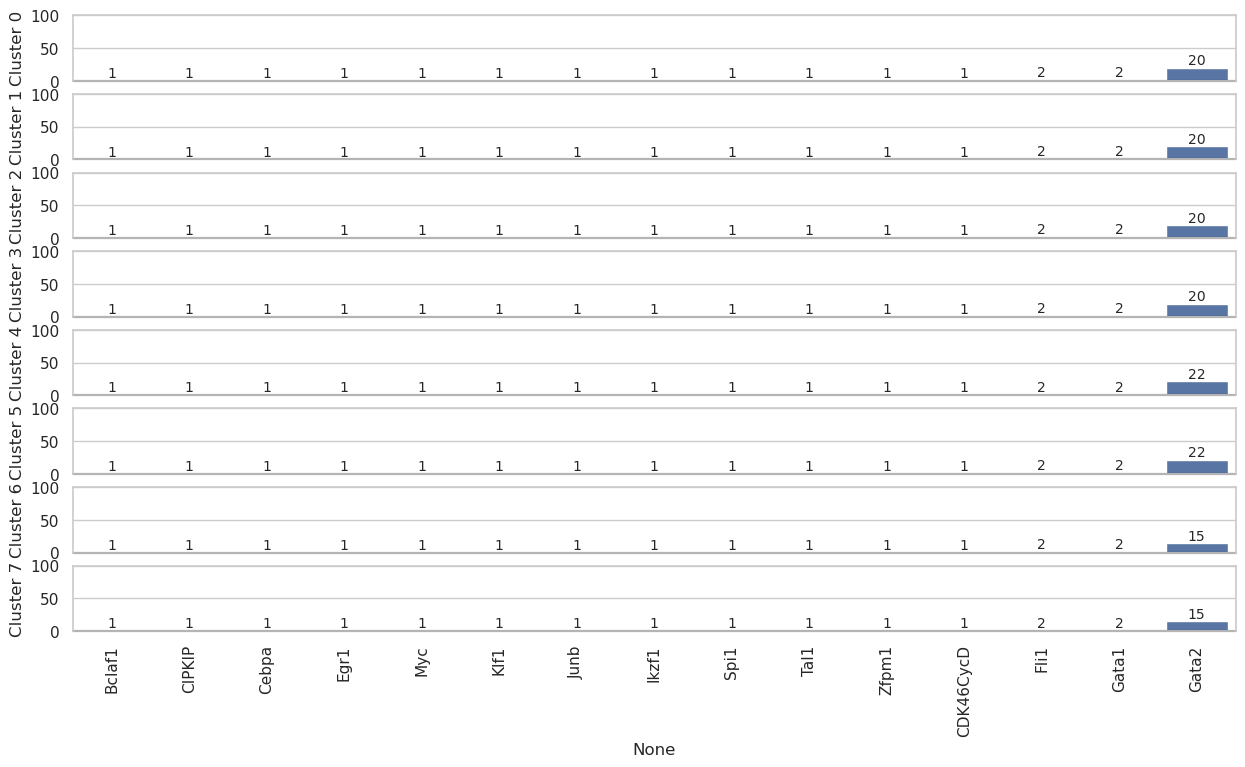

In [42]:
fig, axes = plt.subplots(8, 1, figsize=(15, 8), sharex=True)
plt.ylim(0, 65)

for i in range(8):
    sns.barplot(x=var_logic_clust.index, y=var_logic_clust[i], ax=axes[i])
    axes[i].axhline(0, color="k", clip_on=False)
    axes[i].set_ylabel(f"Cluster {i}")
    axes[i].bar_label(axes[i].containers[0], fontsize=10)
    axes[i].set_ylim(0, 100)

plt.xticks(rotation=90)
plt.show()

In [43]:
from scipy.stats import chi2_contingency

test = model.logic.logic_clause_flattend
test = test.transpose()
test['group'] = test.index.map(model.trajectory.cluster_dict)
# Assuming 'df' is a DataFrame with samples as rows and features as columns,
# and 'group' is a column indicating group membership.

# Step 1: Identify constant features.
constant_features = [col for col in test.columns if col != 'group' and test[col].nunique() == 1]

# Step 2 & 3: For non-constant features, perform chi-square test.
marker_features = []
varied_features = []

for col in test.columns:
    if col == 'group' or col in constant_features:
        continue
    contingency_table = pd.crosstab(test[col], test['group'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    if p < 0.001:  # Adjust threshold as needed after multiple testing correction.
        marker_features.append(col)
    else:
        varied_features.append(col)

print("Constant features:", constant_features)
print("Varied but not markers:", varied_features)
print("Key marker features:", marker_features)

Constant features: ['Bclaf1_(Myc)', 'CIPKIP_(Junb)', 'Cebpa_(Gata2 & !Ikzf1)', 'Cebpa_(!Ikzf1 & Spi1)', 'Egr1_(Gata2 & Junb)', 'Fli1_(Gata1 & !Klf1)', 'Gata1_(Fli1)', 'Gata1_(Gata2 & !Spi1)', 'Ikzf1_(Gata2)', 'Junb_(Myc)', 'Junb_(Egr1)', 'Klf1_(!Fli1 & Gata1)', 'Myc_(Bclaf1 & Cebpa)', 'Spi1_(Cebpa & !Gata1 & !Gata2)', 'Spi1_(!Gata1 & Spi1)', 'Tal1_(Gata1 & !Spi1)', 'Zfpm1_(Gata1)']
Varied but not markers: ['Fli1_(Junb)', 'Gata1_(Gata1 & !Ikzf1)', 'Gata2_(Egr1 & !Gata1 & !Spi1)', 'Gata2_(Egr1 & !Zfpm1)', 'Fli1_(Gata1 & Junb)', 'Fli1_(Junb & !Klf1)', 'Gata2_(Egr1 & !Gata1 & !Zfpm1)', 'Gata1_(Gata1 & !Ikzf1 & !Spi1)', 'Gata2_(Egr1 & !Gata1 & !Spi1 & !Zfpm1)', 'Gata2_(Egr1 & !Gata1)', 'Gata2_(Egr1 & !Spi1 & !Zfpm1)']
Key marker features: ['CDK46CycD_(Bclaf1 & Myc)', 'Gata2_(!Gata1 & Gata2 & !Zfpm1)', 'Gata2_(Egr1 & Gata2 & !Spi1 & !Zfpm1)', 'Gata2_(!Gata1 & Gata2)', 'Gata2_(!Gata1 & Gata2 & !Spi1)', 'Gata2_(Gata2 & !Zfpm1)', 'CDK46CycD_(Myc)', 'CDK46CycD_(Bclaf1)', 'Gata2_(Gata2 & !Spi1 & 

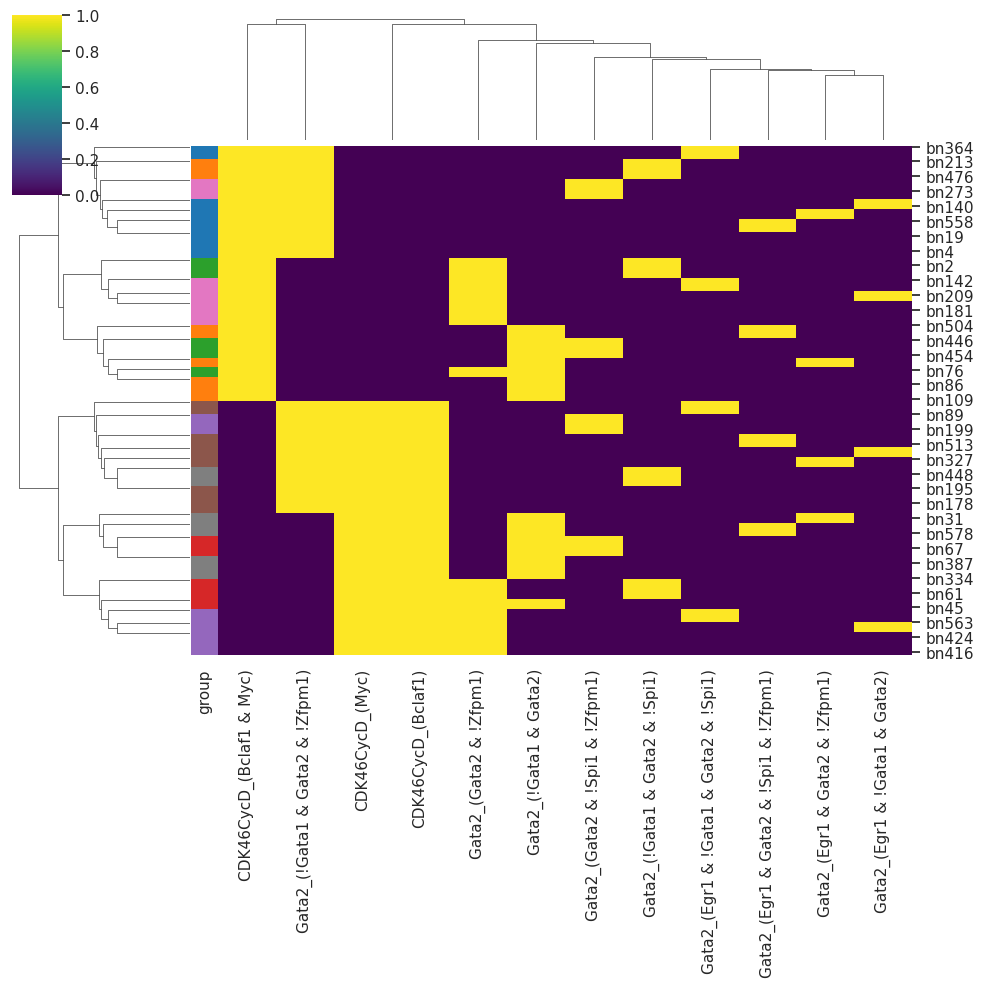

In [44]:
# Create a color palette for the groups
unique_groups = test['group'].unique()
palette = sns.color_palette("tab10", len(unique_groups))
group_colors = test['group'].map(dict(zip(unique_groups, palette)))

# Create the clustermap with row colors
sns.clustermap(test[marker_features], cmap='viridis', figsize=(10, 10), row_colors=group_colors)

In [45]:
model_cluster = pd.Series(model.trajectory.cluster_dict)
test = model.logic.logic_clause_flattend
result_df = pd.DataFrame()

for cluster in model.trajectory.cluster_dict.values():
    cluster_id = [key for key, value in model.trajectory.cluster_dict.items() if value == cluster]
    cluster_mtx = test.loc[:, test.columns.isin(cluster_id)]
    cluster_mean = cluster_mtx.mean(axis=1)
    result_df[f'Cluster_{cluster}'] = cluster_mean
result_df

,Cluster_6,Cluster_7,Cluster_5,Cluster_0,Cluster_1,Cluster_3,Cluster_2,Cluster_4
Bclaf1_(Myc),1.000000,1.000000,1.000000,1.00,1.00,1.00,1.00,1.000000
CDK46CycD_(Bclaf1 & Myc),0.000000,1.000000,0.000000,0.00,0.00,1.00,1.00,1.000000
CIPKIP_(Junb),1.000000,1.000000,1.000000,1.00,1.00,1.00,1.00,1.000000
Cebpa_(Gata2 & !Ikzf1),1.000000,1.000000,1.000000,1.00,1.00,1.00,1.00,1.000000
Cebpa_(!Ikzf1 & Spi1),1.000000,1.000000,1.000000,1.00,1.00,1.00,1.00,1.000000
Egr1_(Gata2 & Junb),1.000000,1.000000,1.000000,1.00,1.00,1.00,1.00,1.000000
Fli1_(Junb),0.500000,0.500000,0.500000,0.50,0.50,0.50,0.50,0.500000
Fli1_(Gata1 & !Klf1),1.000000,1.000000,1.000000,1.00,1.00,1.00,1.00,1.000000
Gata1_(Fli1),1.000000,1.000000,1.000000,1.00,1.00,1.00,1.00,1.000000
Gata1_(Gata1 & !Ikzf1),0.500000,0.500000,0.500000,0.50,0.50,0.50,0.50,0.500000


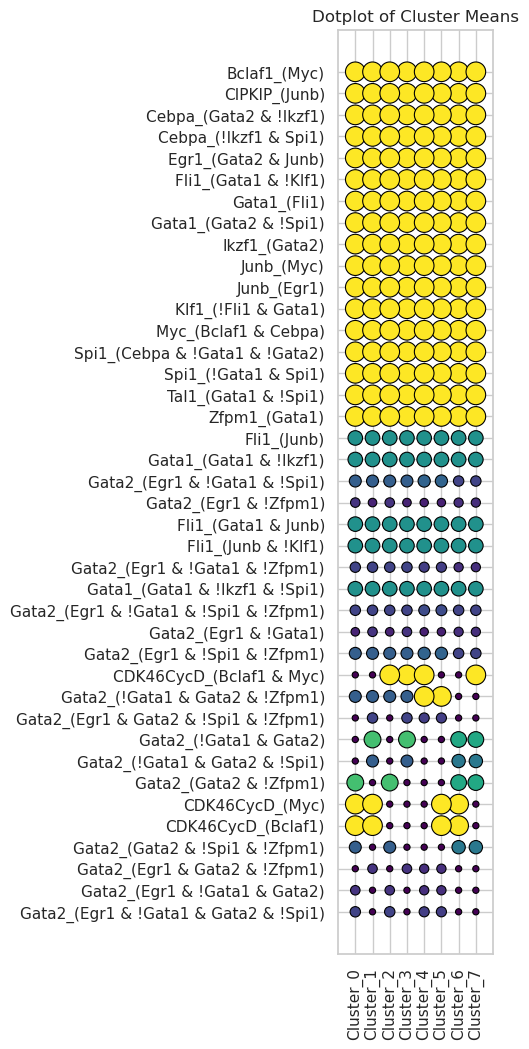

In [48]:
model_cluster = pd.Series(model.trajectory.cluster_dict)
test = model.logic.logic_clause_flattend
result_df = pd.DataFrame()

for cluster in model.trajectory.cluster_dict.values():
    cluster_id = [key for key, value in model.trajectory.cluster_dict.items() if value == cluster]
    cluster_mtx = test.loc[:, test.columns.isin(cluster_id)]
    cluster_mean = cluster_mtx.mean(axis=1)
    result_df[f'Cluster_{cluster}'] = cluster_mean

# Convert the result_df to a long format for easier plotting with seaborn
result_df = result_df.loc[constant_features + varied_features + marker_features,:]
result_long_df = result_df.reset_index().melt(id_vars='index', var_name='Cluster', value_name='Value')

# Create the dot plot
plt.figure(figsize=(2, 12))
sns.set_theme(style="whitegrid")
dotplot = sns.scatterplot(data=result_long_df, 
                          x=pd.Categorical(result_long_df['Cluster'], categories=['Cluster_0', 'Cluster_1',
                                                                                  'Cluster_2', 'Cluster_3',
                                                                                  'Cluster_4', 'Cluster_5',
                                                                                  'Cluster_6', 'Cluster_7',], ordered=True), 
                          y='index', 
                          size='Value', hue='Value', 
                          palette='viridis', sizes=(20, 200), legend=None,
                          edgecolor='black', linewidth=0.8)

# Customize the plot
plt.title('Dotplot of Cluster Means')
#plt.xlabel('Cluster')
plt.ylabel(None)
plt.xticks(rotation=90)
plt.xlim(-1,8)
#plt.savefig('/home/spankaew/Git/astrologics/figures/hh_traj_dotplot.pdf', bbox_inches='tight')

plt.show()
plt.close()

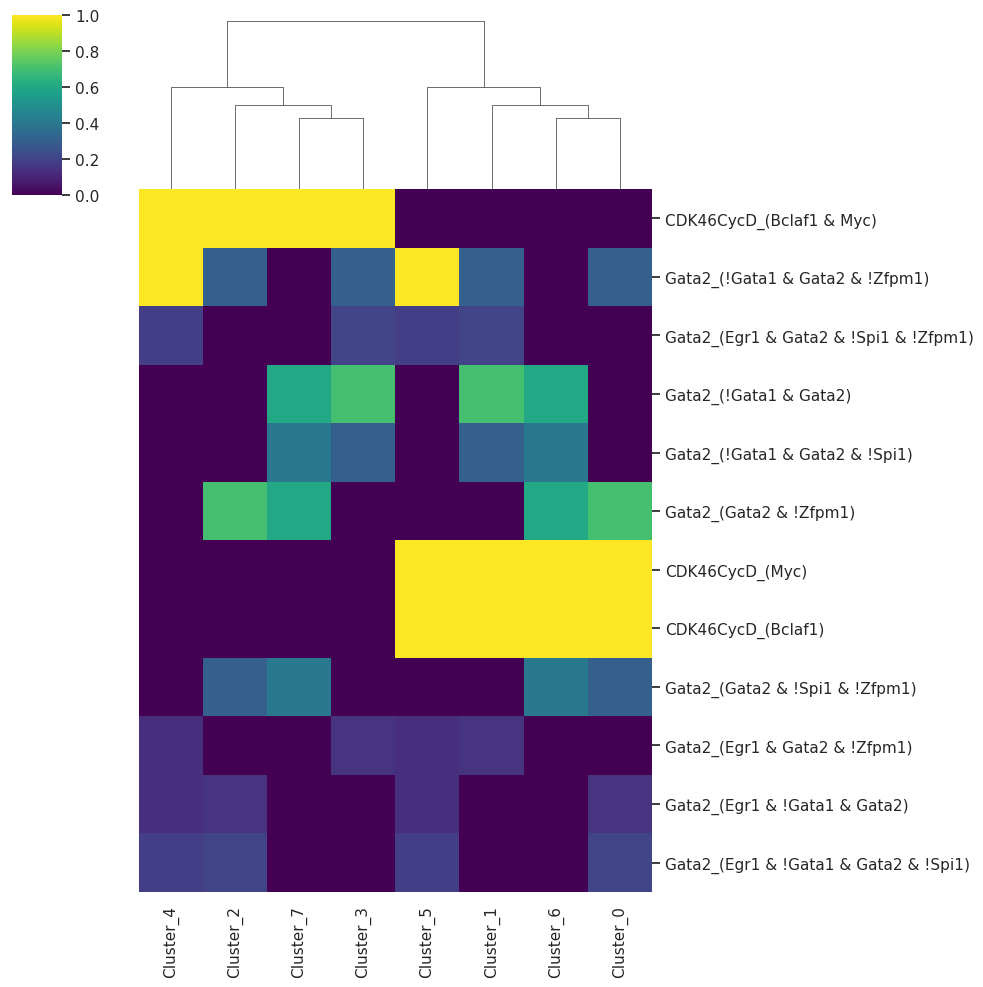

In [53]:
sns.clustermap(result_df.loc[marker_features,:], row_cluster = False, cmap = 'viridis')

In [18]:
import maboss
model_path = '/home/spankaew/Git/astrologics/models/herault_hematopoiesis/'
test = maboss.loadBNet(model_path + 'bn0.bnet')
test.mutate('Spi1','OFF')

{'Spi1': 'OFF'}